In [10]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

class Data():
    def __init__(self,train,test):
        self.test = test
        self.train = train
        print('train : ' + str(self.train.shape))
        print('test: ' + str(self.test.shape))
        
    def describe(self,test=False):
        if test:
            return self.train.describe(), self.test.describe()
        return self.train.describe()
    
    def columns(self):
        return [i for i in self.test.columns if i not in ['connection_id','target']]
    
    def getCustom(self,substring):
        return [i for i in self.columns() if substring in i]

    def drop(self,colName):
        self.train = self.train.drop(colName,axis=1)
        self.test = self.test.drop(colName,axis=1)

    def scaler(self,colName):
        from sklearn.preprocessing import StandardScaler
        std_scale = StandardScaler().fit(self.test[colName])
        self.test[colName] = std_scale.transform(self.test[colName])
        self.train[colName] = std_scale.transform(self.train[colName])

    def decomposition(self):
        classSet = list(set(self.train['target']))
        self.classDict = { i: [1 if j==i else 0 for j in self.train['target']] for i in classSet}

In [11]:
# pd.read_csv('bestTrain.csv').columns

In [12]:
data = Data(pd.read_csv('bestTrain.csv').drop(['connection_id'],1),pd.read_csv('bestTest.csv').drop(['connection_id'],1))

train : (169307, 21)
test: (91166, 20)


In [13]:
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})

    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = dict((label, i) for i, label in enumerate(sorted(set(y))))
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)

    def predict(self, X):
        num2label = dict((i, label)for label, i in self.label2num.items())
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])

    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)

    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self

In [14]:
class SklearnHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self,x_train,y_train):
        return self.clf.fit(x_train,y_train)
        
    def predict(self,x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importance(self,x,y):
        return self.clf.fit(x,y).feature_importances_

In [15]:
# data.drop('Unnamed: 0')
# train_add2 = data.train[(data.train['target'] == 2)]
# print(train_add2.shape)
# train_add1 = data.train[(data.train['target'] == 1)]
# print(train_add1.shape)
# train_add2 = train_add2.append(train_add2.sample(round(0.68*36854)))
# print(train_add2.shape)
# train_add1 = train_add1.append(train_add1.sample(round(0.94*33585)))
# print(train_add1.shape)
# data.train = data.train.append(train_add1)
# data.train  = data.train.append(train_add2)

In [16]:
# ntest = data.test.shape[0]
# ntrain = data.train.shape[0]
# SEED = 0
# NFOLDS = 5
# kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
# def get_oof(clf, x_train, y_train, x_test):
#     oof_train = np.zeros((ntrain,))
#     oof_test = np.zeros((ntest,))
#     oof_test_skf = np.empty((NFOLDS,ntest))
#     for i,(train_index,test_index) in enumerate(kf):
#         x_tr = x_train[train_index]
#         y_tr = y_train[train_index]
#         x_te = x_train[test_index]
        
#         clf.train(x_tr,y_tr)
#         oof_train[test_index] = clf.predict(x_te)
#         oof_test_skf[i, :] = clf.predict(x_test)
        
#     oof_test[:] = oof_test_skf.mean(axis=0)
#     return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

In [17]:
ntest = data.test.shape[0]
ntrain = data.train.shape[0]
SEED = 6734637
NFOLDS = 5
kf_tr = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kf_ts = KFold(ntest, n_folds= NFOLDS, random_state=SEED)
def get_XGoof(params, x_train, y_train, x_test,num_rounds=None):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    for (train_index_tr,test_index_tr),(train_index_ts,test_index_ts) in zip(kf_tr,kf_ts):
        dtrain = xgb.DMatrix(data=x_train[train_index_tr], label=y_train[train_index_tr])
        dte = xgb.DMatrix(data=x_train[test_index_tr])
        dtest = xgb.DMatrix(data=x_test[test_index_ts])   
        
        bst = xgb.train(params,dtrain,num_boost_round=num_rounds)
        oof_train[test_index_tr] = bst.predict(dte)
        oof_test[test_index_ts] = bst.predict(dtest)
        
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

### Balancing the classes

In [18]:
targetValues = data.train["target"].value_counts().index.values
numberOfTarget = data.train["target"].value_counts().values

In [19]:
targetValues

array([0, 2, 1], dtype=int64)

In [20]:
numberOfTarget

array([98868, 36854, 33585], dtype=int64)

# Let us stack now
### Ready the parameters for ensembles

In [21]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 50,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 50,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'C' : 0.025,
    }

In [22]:
import xgboost as xgb


class CustomXGboost:

    def __init__(self,params, num_boost_round=10, maximize=False):
        self.params=params
        self.num_boost_round=num_boost_round
        self.maximize=maximize
        
    def fit(self,train,target):
        dtrain = xgb.DMatrix(data=train, label=target)        
        self.clf = xgb.train(params=params,dtrain=dtrain, num_boost_round=self.num_boost_round, maximize=self.maximize)
        return self.clf
    
    def predict(self,dtest):
        dtest=xgb.DMatrix(data=dtest)
        return self.clf.predict(dtest)

In [23]:
# default parameters
params1 = {}
params1['objective'] = 'multi:softmax'
params1['eta'] = 0.01
params1['silent'] = True
params1['max_depth'] = 6
params1['subsample'] = 0.9
params1['colsample_bytree'] = 0.9
params1['nthread']=-1
params1['num_class']=3

# default parameters
params2 = {}
params2['objective'] = 'multi:softmax'
params2['eta'] = 0.0075
params2['silent'] = True
params2['max_depth'] = 6
params2['subsample'] = 0.9
params2['colsample_bytree'] = 0.9
params2['nthread']=-1
params2['num_class']=3

# default parameters
params3 = {}
params3['objective'] = 'multi:softmax'
params3['eta'] = 0.01
params3['silent'] = True
params3['max_depth'] = 7
params3['subsample'] = 0.9
params3['colsample_bytree'] = 0.9
params3['nthread']=-1
params3['num_class']=3

# clf7=CustomXGboost(params=params1,num_boost_round=631,maximize=True)
# clf8=CustomXGboost(params=params2,num_boost_round=884,maximize=True)
# clf9=CustomXGboost(params=params3,num_boost_round=604,maximize=True)

In [24]:
# rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
# et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
# ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
# gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
# svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

# Numpy array for test and train

In [25]:
y_train = data.train['target'].ravel()
train = data.train[data.columns()]
x_train = train.values # Creates an array of the train data
x_test = data.test[data.columns()].values # Creats an array of the test data

In [26]:
x_train.shape,train.columns

((169307, 20),
 Index(['cont_1', 'cont_2', 'cont_3', 'cont_8', 'cont_9', 'cont_10', 'cont_11',
        'cont_12', 'cont_13', 'cont_14', 'cat_1', 'cat_2', 'cat_3', 'cat_9',
        'cat_20', 'cat_22', 'cat_23', 'cont_17_18_mean', 'cont_15_16_min',
        'is_attack_1'],
       dtype='object'))

In [27]:
y_train.shape
x_test.shape

(91166, 20)

## First level predection

In [28]:
xg1_oof_train, xg1_oof_test = get_XGoof(params1,x_train,y_train,x_test,num_rounds=631)

In [29]:
xg2_oof_train, xg2_oof_test = get_XGoof(params2,x_train,y_train,x_test,num_rounds=850)
print('completed')

completed


In [30]:
xg3_oof_train, xg3_oof_test = get_XGoof(params3,x_train,y_train,x_test,num_rounds=604)
print('completed')

completed


In [31]:
base_predictions_train = pd.DataFrame( {'XGB1': xg1_oof_train.ravel(),
     'XGB2': xg2_oof_train.ravel(),
     'XGB3': xg3_oof_train.ravel()})
base_predictions_train.head()

,XGB1,XGB2,XGB3
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [32]:
base_predictions_test = pd.DataFrame( {'XGB1': xg1_oof_test.ravel(),
     'XGB2': xg2_oof_test.ravel(),
     'XGB3': xg3_oof_test.ravel()})
base_predictions_test.head()

,XGB1,XGB2,XGB3
0,1.0,1.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [33]:
base_predictions_test['XGB1'].value_counts()

0.0    72909
1.0    18217
2.0       40
Name: XGB1, dtype: int64

In [34]:
base_predictions_train['XGB1'].value_counts()

0.0    135356
1.0     33882
2.0        69
Name: XGB1, dtype: int64

# Lets see the corelearion of new features generated

In [35]:
def plotHeatMap(df, size=(16,9),an=True):
    plt.figure(figsize=size)
    cmap = plt.cm.viridis
    sns.heatmap(df.corr(),cmap=cmap,linewidths=0.1,vmax=1, linecolor="white", square=True,annot=an)
    plt.show()

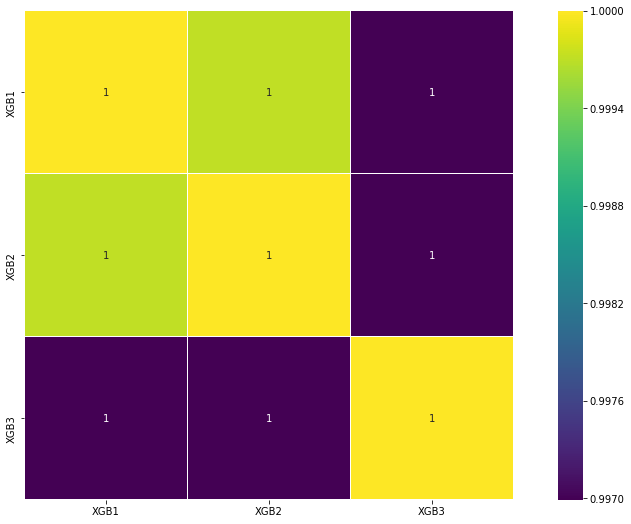

In [36]:
plotHeatMap(base_predictions_train)

In [37]:
x_train = np.concatenate(( xg1_oof_train, xg2_oof_train, xg3_oof_train), axis=1)
x_test = np.concatenate(( xg1_oof_test, xg2_oof_test, xg3_oof_test), axis=1)

In [38]:
import xgboost as xgb

In [39]:
params = {}
params['objective'] = 'multi:softmax'
params['eta'] = 0.01
params['silent'] = True
params['max_depth'] = 6
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9
params['nthread']=-1
params['num_class']=3

In [40]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test)

In [41]:
clf1_2 = xgb.train(params, dtrain, 631,maximize=True)

In [42]:
pred = clf1_2.predict(dtest)

In [43]:
print('Completed')

Completed


In [44]:
pred.shape

(91166,)

In [45]:
sub = pd.read_csv('test_data.csv')
sub['target'] = pred
sub['target'] = sub['target'].astype(int)
sub[['connection_id','target']].to_csv('FirstOwnStack1.csv', index=False)

In [46]:
import pickle
pickle.dump(clf1_2,open('stacked_clf_xgb_meta.sav','wb'))

In [ ]:
pred

In [ ]:
pred.head()

In [104]:
data.train.columns

Index(['connection_id', 'cont_1', 'cont_2', 'cont_3', 'cont_8', 'cont_9',
       'cont_11', 'cont_12', 'cont_13', 'cont_14', 'cat_2', 'cat_3', 'cat_20',
       'cat_22', 'cat_23', 'target', 'cont_17_18_mean', 'cont_15_16_min',
       'is_attack_1'],
      dtype='object')

In [107]:
data.train.to_csv('bestTrain.csv',index=None)
data.test.to_csv('bestTest.csv',index=None)

In [106]:
pd.read_csv('bestTrain.csv').columns

Index(['connection_id', 'cont_1', 'cont_2', 'cont_3', 'cont_8', 'cont_9',
       'cont_11', 'cont_12', 'cont_13', 'cont_14', 'cat_2', 'cat_3', 'cat_20',
       'cat_22', 'cat_23', 'target', 'cont_17_18_mean', 'cont_15_16_min',
       'is_attack_1'],
      dtype='object')